# Load in the data set fruits:

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs'
train_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/training'
val_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/validation'
train_val_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/train_val'
test_dir = '/content/drive/MyDrive/Thesis code/healthy_scab_LDs/test'

# Preprocess the images and apply data augmentation to the training set:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TRAIN_VAL_DIR, TESTING_DIR):

  # preprocessing training images (including data augmentation)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))
  
  # preprocessing training images
  validation_datagen = ImageDataGenerator(rescale = 1/255)

  validation_generator = validation_datagen.flow_from_directory(directory= VALIDATION_DIR,
                                                                shuffle = False,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(224, 224))
  
  # preprocessing train_val images (including data augmentation)
  train_val_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_val_generator = train_val_datagen.flow_from_directory(directory=TRAIN_VAL_DIR, 
                                                              shuffle=True,
                                                              batch_size=32,
                                                              class_mode='binary',
                                                              target_size=(224, 224))
  
  # preprocessing train_val images (including data augmentation)
  testing_datagen = ImageDataGenerator(rescale = 1/255)

  testing_generator = testing_datagen.flow_from_directory(directory= TESTING_DIR,
                                                          shuffle=False,
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          target_size=(224, 224))

  return train_generator, validation_generator, train_val_generator, testing_generator

# Download/import libraries

## Install Optuna (library for the tuning of hyperparameters)

In [ ]:
!pip install optuna

## Importing the necessary libraries (such as Optuna and Tensorflow/Keras)

In [ ]:
import optuna
import tensorflow as tf
import urllib
import warnings

from tensorflow.keras import Model
from keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop
from keras.backend import clear_session

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Basic CNN model:

## Perform hyperparameter tuning on the Basic CNN model.

In [ ]:
def hp_basic_cnn(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)
  first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
  drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])

  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten() ])
  
  for i in range(hidden_layers):
    model.add(Dense(first_neuron, activation='relu'))
    model.add(Dropout(drop_out))

  model.add(Dense(1, activation='sigmoid'))

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])#, Recall(), Precision()
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop])
  
  # evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  print(f1score_macro)
  
  return f1score_macro


if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_basic_cnn, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-7-c5d59712e866>:61: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-15 09:35:14,969] A new study created in memory with name: no-name-022bc0ca-1fd4-467a-a77d-f1935bf9658b


Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 190s 8s/step - loss: 0.8152 - accuracy: 0.4965 - val_loss: 0.6744 - val_accuracy: 0.8481
Epoch 2/100
23/23 [==============================] - 185s 8s/step - loss: 0.6896 - accuracy: 0.4698 - val_loss: 0.5610 - val_accuracy: 0.8270
Epoch 3/100
23/23 [==============================] - 181s 8s/step - loss: 0.6863 - accuracy: 0.5989 - val_loss: 0.7186 - val_accuracy: 0.4304
Epoch 4/100
23/23 [==============================] - 186s 8s/step - loss: 0.6905 - accuracy: 0.6045 - val_loss: 0.7078 - val_accuracy: 0.4726
Epoch 5/100
23/23 [==============================] - 186s 8s/step - loss: 0.6733 - accuracy: 0.6424 - val_loss: 0.6420 - val_accuracy: 0.6287
Epoch 6/100
23/23 [==============================] - 185s 8s/step - loss: 0.6730 - accuracy: 0.6396 - val_loss: 0.6989 - val_a

[I 2023-05-15 09:57:52,465] Trial 0 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00024245257932506282}. Best is trial 0 with value: 0.4526558891454965.


0.4526558891454965
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 194s 8s/step - loss: 0.6955 - accuracy: 0.5778 - val_loss: 0.6818 - val_accuracy: 0.8270
Epoch 2/100
23/23 [==============================] - 182s 8s/step - loss: 0.6909 - accuracy: 0.5652 - val_loss: 0.6858 - val_accuracy: 0.7046
Epoch 3/100
23/23 [==============================] - 185s 8s/step - loss: 0.6880 - accuracy: 0.5470 - val_loss: 0.6758 - val_accuracy: 0.8397
Epoch 4/100
23/23 [==============================] - 184s 8s/step - loss: 0.6829 - accuracy: 0.5778 - val_loss: 0.7021 - val_accuracy: 0.3291
Epoch 5/100
23/23 [==============================] - 186s 8s/step - loss: 0.6981 - accuracy: 0.5568 - val_loss: 0.6745 - val_accuracy: 0.7342
Epoch 6/100
23/23 [==============================] - 185s 8s/step - loss: 0.7038 - accuracy: 0.5778 - val_l

[I 2023-05-15 10:57:12,327] Trial 1 finished with value: 0.6136829359165425 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 1.5520332396597338e-05}. Best is trial 1 with value: 0.6136829359165425.


0.6136829359165425
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 189s 8s/step - loss: 1.7100 - accuracy: 0.4642 - val_loss: 0.7210 - val_accuracy: 0.1730
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.7047 - accuracy: 0.5231 - val_loss: 0.7784 - val_accuracy: 0.1730
Epoch 3/100
23/23 [==============================] - 181s 8s/step - loss: 0.7246 - accuracy: 0.4488 - val_loss: 0.6594 - val_accuracy: 0.8439
Epoch 4/100
23/23 [==============================] - 182s 8s/step - loss: 0.6999 - accuracy: 0.4937 - val_loss: 0.6819 - val_accuracy: 0.5907
Epoch 5/100
23/23 [==============================] - 188s 8s/step - loss: 0.7012 - accuracy: 0.6101 - val_loss: 0.6448 - val_accuracy: 0.8776
Epoch 6/100
23/23 [==============================] - 186s 8s/step - loss: 0.6895 - accuracy: 0.6031 - val_l

[I 2023-05-15 11:31:54,081] Trial 2 finished with value: 0.669474144767426 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.001239918094918828}. Best is trial 2 with value: 0.669474144767426.


0.669474144767426
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 189s 8s/step - loss: 0.7032 - accuracy: 0.6311 - val_loss: 0.6504 - val_accuracy: 0.8565
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.6884 - accuracy: 0.5554 - val_loss: 0.5969 - val_accuracy: 0.8523
Epoch 3/100
23/23 [==============================] - 180s 8s/step - loss: 0.6899 - accuracy: 0.6003 - val_loss: 0.6925 - val_accuracy: 0.5443
Epoch 4/100
23/23 [==============================] - 184s 8s/step - loss: 0.6630 - accuracy: 0.5849 - val_loss: 0.5964 - val_accuracy: 0.7342
Epoch 5/100
23/23 [==============================] - 183s 8s/step - loss: 0.6689 - accuracy: 0.6466 - val_loss: 0.7223 - val_accuracy: 0.5232
Epoch 6/100
23/23 [==============================] - 186s 8s/step - loss: 0.6564 - accuracy: 0.6410 - val_lo

[I 2023-05-15 12:00:32,966] Trial 3 finished with value: 0.629439356712084 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 4.080533715588306e-05}. Best is trial 2 with value: 0.669474144767426.


0.629439356712084
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 192s 8s/step - loss: 0.7059 - accuracy: 0.6985 - val_loss: 0.7011 - val_accuracy: 0.1772
Epoch 2/100
23/23 [==============================] - 187s 8s/step - loss: 0.6912 - accuracy: 0.5133 - val_loss: 0.6840 - val_accuracy: 0.6793
Epoch 3/100
23/23 [==============================] - 185s 8s/step - loss: 0.6865 - accuracy: 0.5891 - val_loss: 0.6795 - val_accuracy: 0.6329
Epoch 4/100
23/23 [==============================] - 182s 8s/step - loss: 0.6817 - accuracy: 0.5512 - val_loss: 0.6882 - val_accuracy: 0.5527
Epoch 5/100
23/23 [==============================] - 185s 8s/step - loss: 0.6812 - accuracy: 0.5989 - val_loss: 0.6450 - val_accuracy: 0.6878
Epoch 6/100
23/23 [==============================] - 186s 8s/step - loss: 0.6714 - accuracy: 0.5919 - val_lo

[I 2023-05-15 12:56:37,730] Trial 4 finished with value: 0.6476107465135357 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 2.881977764573328e-05}. Best is trial 2 with value: 0.669474144767426.


0.6476107465135357
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 189s 8s/step - loss: 0.7067 - accuracy: 0.5049 - val_loss: 0.6367 - val_accuracy: 0.8270
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.6987 - accuracy: 0.6157 - val_loss: 0.6640 - val_accuracy: 0.8270
Epoch 3/100
23/23 [==============================] - 184s 8s/step - loss: 0.6983 - accuracy: 0.6396 - val_loss: 0.6785 - val_accuracy: 0.8270
Epoch 4/100
23/23 [==============================] - 183s 8s/step - loss: 0.6957 - accuracy: 0.5891 - val_loss: 0.6833 - val_accuracy: 0.8228
Epoch 5/100
23/23 [==============================] - 182s 8s/step - loss: 0.6923 - accuracy: 0.6185 - val_loss: 0.6974 - val_accuracy: 0.3629
Epoch 6/100
8/8 [==============================] - 43s 5s/step


[I 2023-05-15 13:15:52,972] Trial 5 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 3.061741280012905e-05}. Best is trial 2 with value: 0.669474144767426.


0.4526558891454965
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 190s 8s/step - loss: 0.7894 - accuracy: 0.6003 - val_loss: 0.6477 - val_accuracy: 0.8270
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.6939 - accuracy: 0.6788 - val_loss: 0.6624 - val_accuracy: 0.6793
Epoch 3/100
23/23 [==============================] - 181s 8s/step - loss: 0.6863 - accuracy: 0.6339 - val_loss: 0.7128 - val_accuracy: 0.4346
Epoch 4/100
23/23 [==============================] - 183s 8s/step - loss: 0.6757 - accuracy: 0.6410 - val_loss: 0.5982 - val_accuracy: 0.7511
Epoch 5/100
23/23 [==============================] - 183s 8s/step - loss: 0.6682 - accuracy: 0.4769 - val_loss: 0.5399 - val_accuracy: 0.7426
Epoch 6/100
23/23 [==============================] - 185s 8s/step - loss: 0.6698 - accuracy: 0.6199 - val_l

[I 2023-05-15 13:47:29,310] Trial 6 finished with value: 0.6318470039980646 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0006056818435462832}. Best is trial 2 with value: 0.669474144767426.


0.6318470039980646
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 188s 8s/step - loss: 0.7672 - accuracy: 0.5231 - val_loss: 0.6831 - val_accuracy: 0.8270
Epoch 2/100
23/23 [==============================] - 185s 8s/step - loss: 0.7047 - accuracy: 0.5470 - val_loss: 0.6808 - val_accuracy: 0.8270
Epoch 3/100
23/23 [==============================] - 186s 8s/step - loss: 0.6983 - accuracy: 0.6830 - val_loss: 0.5945 - val_accuracy: 0.8270
Epoch 4/100
23/23 [==============================] - 181s 8s/step - loss: 0.7043 - accuracy: 0.6494 - val_loss: 0.7389 - val_accuracy: 0.3586
Epoch 5/100
23/23 [==============================] - 186s 8s/step - loss: 0.7043 - accuracy: 0.6339 - val_loss: 0.7033 - val_accuracy: 0.3629
Epoch 6/100
23/23 [==============================] - 184s 8s/step - loss: 0.7121 - accuracy: 0.4712 - val_l

[I 2023-05-15 14:13:06,242] Trial 7 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0018185747467442438}. Best is trial 2 with value: 0.669474144767426.


0.4526558891454965
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 189s 8s/step - loss: 0.7672 - accuracy: 0.4909 - val_loss: 0.6098 - val_accuracy: 0.8270
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.6933 - accuracy: 0.7405 - val_loss: 0.6173 - val_accuracy: 0.8481
Epoch 3/100
23/23 [==============================] - 183s 8s/step - loss: 0.6945 - accuracy: 0.4067 - val_loss: 0.6904 - val_accuracy: 0.5823
Epoch 4/100
23/23 [==============================] - 183s 8s/step - loss: 0.6912 - accuracy: 0.6564 - val_loss: 0.6117 - val_accuracy: 0.7679
Epoch 5/100
23/23 [==============================] - 185s 8s/step - loss: 0.6744 - accuracy: 0.5835 - val_loss: 0.6497 - val_accuracy: 0.7257
Epoch 6/100
8/8 [==============================] - 46s 6s/step


[I 2023-05-15 14:32:34,337] Trial 8 finished with value: 0.4526558891454965 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0005445726675956471}. Best is trial 2 with value: 0.669474144767426.


0.4526558891454965
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 193s 8s/step - loss: 0.6964 - accuracy: 0.6101 - val_loss: 0.6710 - val_accuracy: 0.6245
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.6787 - accuracy: 0.5778 - val_loss: 0.8311 - val_accuracy: 0.1899
Epoch 3/100
23/23 [==============================] - 181s 8s/step - loss: 0.6649 - accuracy: 0.6213 - val_loss: 0.6723 - val_accuracy: 0.5612
Epoch 4/100
23/23 [==============================] - 187s 8s/step - loss: 0.6643 - accuracy: 0.5288 - val_loss: 0.4726 - val_accuracy: 0.8312
Epoch 5/100
23/23 [==============================] - 184s 8s/step - loss: 0.6809 - accuracy: 0.5919 - val_loss: 0.6939 - val_accuracy: 0.4979
Epoch 6/100
23/23 [==============================] - 183s 8s/step - loss: 0.6540 - accuracy: 0.5989 - val_l

[I 2023-05-15 15:01:10,266] Trial 9 finished with value: 0.6070954907161803 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 4.011987108453446e-05}. Best is trial 2 with value: 0.669474144767426.


0.6070954907161803
Number of finished trials: 10
Best trial:
  Value: 0.669474144767426
  Params: 
    hidden_layers: 2
    first_neuron: 512
    drop_out: 0
    optimizer: RMSprop
    lr: 0.001239918094918828


In [ ]:
trials_df_ = study.trials_dataframe()
trials_df_

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.452656,2023-05-15 09:35:14.972206,2023-05-15 09:57:52.465045,0 days 00:22:37.492839,0.5,256,2,0.000242,RMSprop,COMPLETE
1,1,0.613683,2023-05-15 09:57:52.467209,2023-05-15 10:57:12.327324,0 days 00:59:19.860115,0.5,128,2,0.000016,RMSprop,COMPLETE
2,2,0.669474,2023-05-15 10:57:12.329114,2023-05-15 11:31:54.081525,0 days 00:34:41.752411,0.0,512,2,0.001240,RMSprop,COMPLETE
3,3,0.629439,2023-05-15 11:31:54.082825,2023-05-15 12:00:32.966226,0 days 00:28:38.883401,0.0,256,2,0.000041,Adam,COMPLETE
4,4,0.647611,2023-05-15 12:00:32.967674,2023-05-15 12:56:37.730532,0 days 00:56:04.762858,0.0,128,2,0.000029,RMSprop,COMPLETE
5,5,0.452656,2023-05-15 12:56:37.731790,2023-05-15 13:15:52.972518,0 days 00:19:15.240728,0.5,128,2,0.000031,RMSprop,COMPLETE
6,6,0.631847,2023-05-15 13:15:52.974445,2023-05-15 13:47:29.310660,0 days 00:31:36.336215,0.5,512,2,0.000606,AdamW,COMPLETE
7,7,0.452656,2023-05-15 13:47:29.312364,2023-05-15 14:13:06.242166,0 days 00:25:36.929802,0.5,256,2,0.001819,RMSprop,COMPLETE
8,8,0.452656,2023-05-15 14:13:06.244099,2023-05-15 14:32:34.337442,0 days 00:19:28.093343,0.3,128,2,0.000545,Adam,COMPLETE
9,9,0.607095,2023-05-15 14:32:34.338799,2023-05-15 15:01:10.265966,0 days 00:28:35.927167,0.0,256,1,0.000040,AdamW,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
# Play an audio beep. Any audio URL will do.
for i in range(10):
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

## Re-train the Basic CNN model using the best hyperparameters.

In [ ]:
clear_session()

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = study.best_params['hidden_layers']
best_neurons = study.best_params['first_neuron']
best_dropout = study.best_params['drop_out']
best_optimizer = study.best_params['optimizer']
best_lr = study.best_params['lr']
epochs =6 # take best epoch from HP tuning trail

# retrain model
model = tf.keras.models.Sequential([ 
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten() ])
  
for i in range(best_hidden_layers):
  model.add(Dense(best_neurons, activation='relu'))
  model.add(Dropout(best_dropout))

model.add(Dense(1, activation='sigmoid'))

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)

model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

basic_cnn_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                              class_weight=class_weights_train_val, epochs = epochs, 
                              max_queue_size=40, workers=4, use_multiprocessing=True)

Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/6
30/30 [==============================] - 117s 4s/step - loss: 1.1434 - accuracy: 0.4221 - recall: 0.3707 - precision: 0.8410 - val_loss: 0.9001 - val_accuracy: 0.1750 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/6
30/30 [==============================] - 73s 2s/step - loss: 0.7271 - accuracy: 0.3284 - recall: 0.2293 - precision: 0.8451 - val_loss: 0.6847 - val_accuracy: 0.8250 - val_recall: 0.9091 - val_precision: 0.8824
Epoch 3/6
30/30 [==============================] - 82s 3s/step - loss: 0.6684 - accuracy: 0.6895 - recall: 0.7439 - precision: 0.8614 - val_loss: 0.6670 - val_accuracy: 0.7625 - val_recall: 0.8485 - val_precision: 0.8615
Epoch 4/6
30/30 [==============================] - 82s 2s/step - loss: 0.6786 - accuracy: 0.6937 - recall: 0.7439 - precision: 0.8665 - val_loss: 0.7548 - val_accur

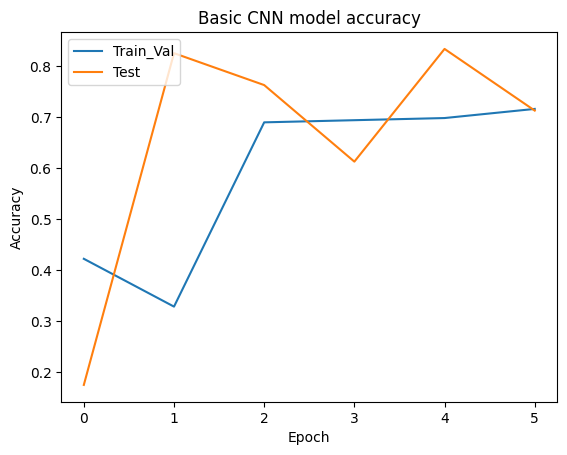

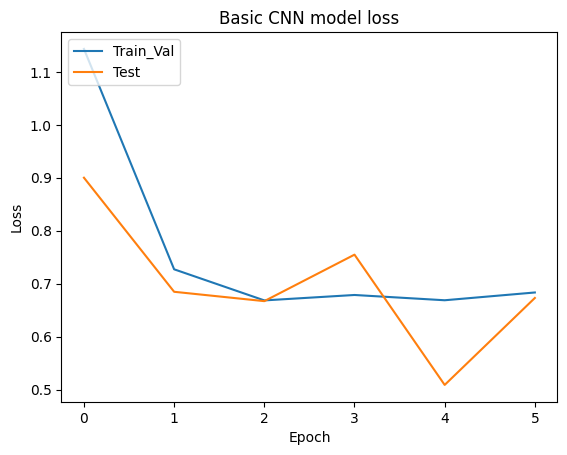

In [ ]:
# Plot training and validation accuracy curves
plt.plot(basic_cnn_history.history['accuracy'])
plt.plot(basic_cnn_history.history['val_accuracy'])
plt.title('Basic CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(basic_cnn_history.history['loss'])
plt.plot(basic_cnn_history.history['val_loss'])
plt.title('Basic CNN model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the Basic CNN model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_basic_cnn = model.evaluate(test)
print('Test loss:', performance_basic_cnn[0])
print('Test accuracy:', performance_basic_cnn[1])

8/8 [==============================] - 45s 6s/step - loss: 0.6730 - accuracy: 0.7125 - recall: 0.7778 - precision: 0.8603
Test loss: 0.6729777455329895
Test accuracy: 0.7124999761581421


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

8/8 [==============================] - 44s 5s/step
Accuracy: 0.7125
Precision: 0.8603351955307262
Recall: 0.7777777777777778
F1-score: 0.8169761273209548
F1_score_macro: 0.5735366073497978
AUC-ROC: 0.5912698412698413

              precision    recall  f1-score   support

           0       0.28      0.40      0.33        42
           1       0.86      0.78      0.82       198

    accuracy                           0.71       240
   macro avg       0.57      0.59      0.57       240
weighted avg       0.76      0.71      0.73       240



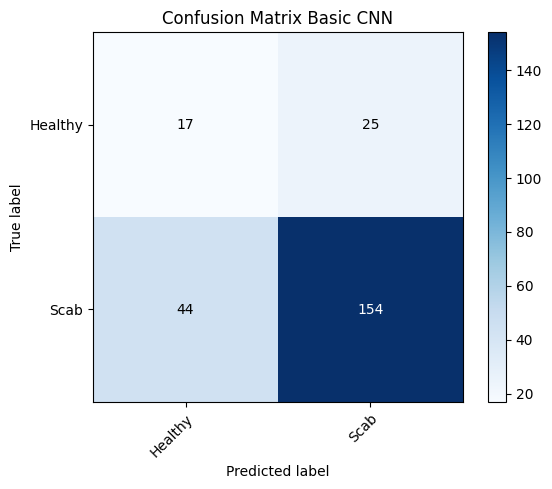

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Basic CNN")
plt.show()

#  ResNet50V2 model:

## Perform hyperparameter tuning on the ResNet50V2 model.

In [ ]:
def hp_fruits_ResNet50V2(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import ResNet50V2
  from tensorflow.keras import layers

  ResNet50V2_model = ResNet50V2(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet')

  for layer in ResNet50V2_model.layers:
    layer.trainable = False

  last_output = ResNet50V2_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512, 768])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(ResNet50V2_model.input, x) 

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  
  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop],
            max_queue_size=40, workers=4, use_multiprocessing=True)
  
  # evaluate macro f1 score
  
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  acc = accuracy_score(val.labels, y_pred_val)
  print(f1score_macro)
  print(acc)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_ResNet50V2, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.675698,2023-05-15 15:23:24.931339,2023-05-15 15:38:35.741407,0 days 00:15:10.810068,0.0,128,1,0.000766,Adam,COMPLETE
1,1,0.704136,2023-05-15 15:38:35.743696,2023-05-15 15:56:41.281370,0 days 00:18:05.537674,0.0,512,2,0.000047,Adam,COMPLETE
2,2,0.720906,2023-05-15 15:56:41.283729,2023-05-15 16:06:43.954039,0 days 00:10:02.670310,0.0,512,2,0.000048,RMSprop,COMPLETE
3,3,0.703278,2023-05-15 16:06:43.956161,2023-05-15 16:22:07.412415,0 days 00:15:23.456254,0.3,256,2,0.000109,RMSprop,COMPLETE
4,4,0.665988,2023-05-15 16:22:07.414584,2023-05-15 16:30:53.392873,0 days 00:08:45.978289,0.3,512,2,0.000365,RMSprop,COMPLETE
5,5,0.657833,2023-05-15 16:30:53.395052,2023-05-15 16:40:45.217488,0 days 00:09:51.822436,0.0,128,2,0.000096,RMSprop,COMPLETE
6,6,0.762777,2023-05-15 16:40:45.219541,2023-05-15 17:04:21.098538,0 days 00:23:35.878997,0.3,256,1,0.000295,RMSprop,COMPLETE
7,7,0.485755,2023-05-15 17:04:21.100684,2023-05-15 17:14:25.824889,0 days 00:10:04.724205,0.3,128,2,0.002221,Adam,COMPLETE
8,8,0.587946,2023-05-15 17:14:25.827150,2023-05-15 17:23:13.472694,0 days 00:08:47.645544,0.3,128,2,0.001013,Adam,COMPLETE
9,9,0.730250,2023-05-15 17:23:13.474946,2023-05-15 17:36:33.678280,0 days 00:13:20.203334,0.5,768,1,0.000013,AdamW,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Re-train the ResNet50V2 model using the best hyperparameters.

In [ ]:
clear_session()

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = 1# study.best_params['hidden_layers']
best_neurons = 256 #study.best_params['first_neuron']
best_dropout = 0.3 #study.best_params['drop_out']
best_optimizer = 'RMSprop' #study.best_params['optimizer']
best_lr = 0.000295	#study.best_params['lr']
epochs = 15 # take best epoch from HP tuning trail

# retrain model
ResNet50V2_model = ResNet50V2(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in ResNet50V2_model.layers:
  layer.trainable = False

last_output = ResNet50V2_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(ResNet50V2_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ResNet50V2_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                               class_weight=class_weights_train_val, epochs = epochs,
                               max_queue_size=40, workers=4, use_multiprocessing=True)

Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
94668760/94668760 [==============================] - 6s 0us/step
Epoch 1/15
30/30 [==============================] - 221s 7s/step - loss: 4.1540 - accuracy: 0.6053 - recall: 0.6166 - precision: 0.8674 - val_loss: 1.4120 - val_accuracy: 0.5542 - val_recall: 0.5152 - val_precision: 0.9027
Epoch 2/15
30/30 [==============================] - 76s 2s/step - loss: 1.1717 - accuracy: 0.6537 - recall: 0.6675 - precision: 0.8851 - val_loss: 0.8385 - val_accuracy: 0.5750 - val_recall: 0.5202 - val_precision: 0.9364
Epoch 3/15
30/30 [==============================] - 82s 3s/step - loss: 0.9702 - accuracy: 0.6758 - recall: 0.6892 - precision: 0.8942 - val_loss: 0.8429 - val_accuracy: 0.5708 - val_recall: 0.5253 - val_precision: 0.9204
Epoch 4/15
30/30 [==============================] - 80s 2s/step - loss: 0.7854 - accuracy: 0.7074 - reca

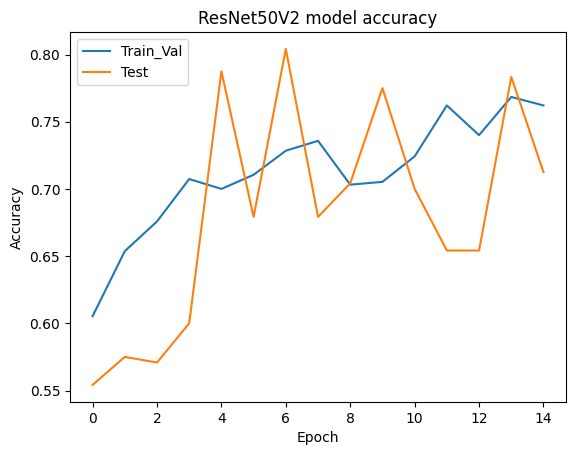

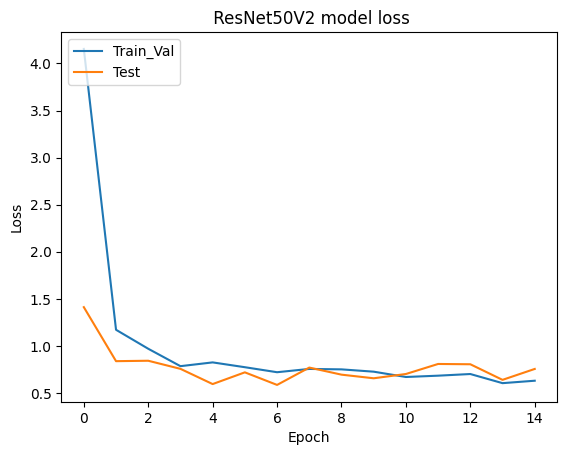

In [ ]:
# Plot training and validation accuracy curves
plt.plot(ResNet50V2_history.history['accuracy'])
plt.plot(ResNet50V2_history.history['val_accuracy'])
plt.title('ResNet50V2 model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(ResNet50V2_history.history['loss'])
plt.plot(ResNet50V2_history.history['val_loss'])
plt.title(' ResNet50V2 model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the ResNet50V2 model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_ResNet50V2 = model.evaluate(test)
print('Test loss:', performance_ResNet50V2[0])
print('Test accuracy:', performance_ResNet50V2[1])

8/8 [==============================] - 45s 5s/step - loss: 0.7559 - accuracy: 0.7125 - recall: 0.7020 - precision: 0.9329
Test loss: 0.7558514475822449
Test accuracy: 0.7124999761581421


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

8/8 [==============================] - 46s 6s/step
Accuracy: 0.7125
Precision: 0.9328859060402684
Recall: 0.702020202020202
F1-score: 0.8011527377521613
F1_score_macro: 0.6411778726354792
AUC-ROC: 0.7319624819624818

              precision    recall  f1-score   support

           0       0.35      0.76      0.48        42
           1       0.93      0.70      0.80       198

    accuracy                           0.71       240
   macro avg       0.64      0.73      0.64       240
weighted avg       0.83      0.71      0.75       240



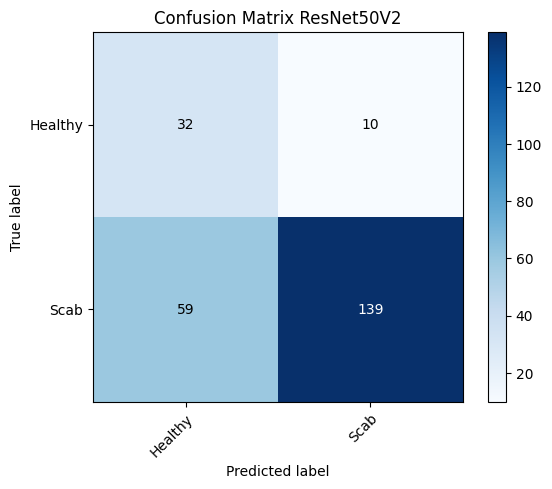

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ResNet50V2")
plt.show()

# EfficientNetV2B0 model:

## Perform hyperparameter tuning on the EfficientNetV2B0 model.

In [ ]:
def hp_fruits_EfficientNetV2B0(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import EfficientNetV2B0
  from tensorflow.keras import layers

  EfficientNetV2B0_model = EfficientNetV2B0(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet',
                                  include_preprocessing = False)

  for layer in EfficientNetV2B0_model.layers:
    layer.trainable = False

  last_output = EfficientNetV2B0_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(EfficientNetV2B0_model.input, x)

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop],
            max_queue_size=20, workers=2, use_multiprocessing=True)
  
  # evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  acc = accuracy_score(val.labels, y_pred_val)
  print(f1score_macro)
  print(acc)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_EfficientNetV2B0, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-12-2c637992ec41>:70: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-15 18:40:39,348] A new study created in memory with name: no-name-88e4a16b-f739-49ec-a7a4-b1fbe9e47ec6


Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
24274472/24274472 [==============================] - 2s 0us/step
Epoch 1/100
23/23 [==============================] - 360s 16s/step - loss: 16.5781 - accuracy: 0.5849 - recall: 0.6112 - precision: 0.8431 - val_loss: 2.5726 - val_accuracy: 0.8270 - val_recall: 1.0000 - val_precision: 0.8270
Epoch 2/100
23/23 [==============================] - 101s 4s/step - loss: 3.7005 - accuracy: 0.5470 - recall: 0.5484 - precision: 0.8500 - val_loss: 0.5614 - val_accuracy: 0.7089 - val_recall: 0.7959 - val_precision: 0.8432
Epoch 3/100
23/23 [==============================] - 104s 4s/step - loss: 1.8348 - accuracy: 0.4250 - recall: 0.3837 - precision: 0.8278 - val_loss: 0.8904 - val_accuracy: 0.2363 - val_recall: 0.0867 - val_precision: 0.8947
Epoch 4/100
23/23 [==============================] - 106s 5s/step - loss: 1.6646 - accuracy: 0.25

[I 2023-05-15 18:58:29,142] Trial 0 finished with value: 0.538481076962154 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0034586306630641404}. Best is trial 0 with value: 0.538481076962154.


0.538481076962154
0.7088607594936709
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 118s 5s/step - loss: 1.8329 - accuracy: 0.5806 - recall: 0.5976 - precision: 0.8502 - val_loss: 0.7450 - val_accuracy: 0.6371 - val_recall: 0.6173 - val_precision: 0.9167
Epoch 2/100
23/23 [==============================] - 101s 4s/step - loss: 0.9197 - accuracy: 0.6339 - recall: 0.6367 - precision: 0.8886 - val_loss: 0.6244 - val_accuracy: 0.6540 - val_recall: 0.6122 - val_precision: 0.9524
Epoch 3/100
23/23 [==============================] - 106s 4s/step - loss: 0.7133 - accuracy: 0.6718 - recall: 0.6808 - precision: 0.8971 - val_loss: 0.5972 - val_accuracy: 0.6414 - val_recall: 0.6173 - val_precision: 0.9237
Epoch 4/100
23/23 [==============================] - 105s 4s/step - loss: 0.7766 - accuracy: 0.6424 - recall: 0.6503 - precisio

[I 2023-05-15 19:19:07,426] Trial 1 finished with value: 0.6749160951408143 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00020379047848451774}. Best is trial 1 with value: 0.6749160951408143.


0.6749160951408143
0.8016877637130801
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 118s 5s/step - loss: 0.9216 - accuracy: 0.5680 - recall: 0.5857 - precision: 0.8435 - val_loss: 0.6881 - val_accuracy: 0.5949 - val_recall: 0.5714 - val_precision: 0.9032
Epoch 2/100
23/23 [==============================] - 104s 4s/step - loss: 0.6761 - accuracy: 0.6003 - recall: 0.5942 - precision: 0.8838 - val_loss: 0.5001 - val_accuracy: 0.8228 - val_recall: 0.9235 - val_precision: 0.8702
Epoch 3/100
23/23 [==============================] - 103s 4s/step - loss: 0.6060 - accuracy: 0.6255 - recall: 0.5891 - precision: 0.9328 - val_loss: 0.4693 - val_accuracy: 0.8228 - val_recall: 0.8929 - val_precision: 0.8929
Epoch 4/100
23/23 [==============================] - 102s 4s/step - loss: 0.6043 - accuracy: 0.6858 - recall: 0.6978 - precisi

[I 2023-05-15 19:41:33,571] Trial 2 finished with value: 0.7478723404255319 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 5.8893604206950856e-05}. Best is trial 2 with value: 0.7478723404255319.


0.7478723404255319
0.8396624472573839
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 120s 5s/step - loss: 1.1236 - accuracy: 0.6017 - recall: 0.6316 - precision: 0.8474 - val_loss: 0.8019 - val_accuracy: 0.4515 - val_recall: 0.3673 - val_precision: 0.9231
Epoch 2/100
23/23 [==============================] - 104s 4s/step - loss: 0.7310 - accuracy: 0.5764 - recall: 0.5722 - precision: 0.8708 - val_loss: 0.5530 - val_accuracy: 0.6962 - val_recall: 0.7245 - val_precision: 0.8875
Epoch 3/100
23/23 [==============================] - 104s 4s/step - loss: 0.7208 - accuracy: 0.6213 - recall: 0.6316 - precision: 0.8753 - val_loss: 0.6141 - val_accuracy: 0.6371 - val_recall: 0.6020 - val_precision: 0.9365
Epoch 4/100
23/23 [==============================] - 101s 4s/step - loss: 0.7186 - accuracy: 0.6045 - recall: 0.6112 - precisi

[I 2023-05-15 19:55:11,686] Trial 3 finished with value: 0.5937916587316702 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.00011591735940610115}. Best is trial 2 with value: 0.7478723404255319.


0.5937916587316702
0.6962025316455697
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 121s 5s/step - loss: 8.1713 - accuracy: 0.5259 - recall: 0.5552 - precision: 0.8114 - val_loss: 1.4401 - val_accuracy: 0.5105 - val_recall: 0.4592 - val_precision: 0.9000
Epoch 2/100
23/23 [==============================] - 103s 4s/step - loss: 2.3445 - accuracy: 0.5330 - recall: 0.5144 - precision: 0.8657 - val_loss: 0.9539 - val_accuracy: 0.7848 - val_recall: 0.9286 - val_precision: 0.8311
Epoch 3/100
23/23 [==============================] - 104s 4s/step - loss: 1.2497 - accuracy: 0.5722 - recall: 0.5688 - precision: 0.8679 - val_loss: 0.8140 - val_accuracy: 0.6962 - val_recall: 0.7143 - val_precision: 0.8974
Epoch 4/100
23/23 [==============================] - 106s 4s/step - loss: 0.9371 - accuracy: 0.6339 - recall: 0.6553 - precisi

[I 2023-05-15 20:24:57,357] Trial 4 finished with value: 0.6777389277389277 and parameters: {'hidden_layers': 2, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.007106431127372928}. Best is trial 2 with value: 0.7478723404255319.


0.6777389277389277
0.8227848101265823
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 120s 5s/step - loss: 1.3165 - accuracy: 0.5288 - recall: 0.5280 - precision: 0.8428 - val_loss: 0.4761 - val_accuracy: 0.7679 - val_recall: 0.8265 - val_precision: 0.8852
Epoch 2/100
23/23 [==============================] - 104s 4s/step - loss: 0.7263 - accuracy: 0.6452 - recall: 0.6672 - precision: 0.8733 - val_loss: 0.5101 - val_accuracy: 0.7890 - val_recall: 0.8571 - val_precision: 0.8842
Epoch 3/100
23/23 [==============================] - 100s 4s/step - loss: 0.6313 - accuracy: 0.6760 - recall: 0.6995 - precision: 0.8841 - val_loss: 0.6742 - val_accuracy: 0.5696 - val_recall: 0.5357 - val_precision: 0.9052
Epoch 4/100
23/23 [==============================] - 103s 4s/step - loss: 0.6316 - accuracy: 0.6269 - recall: 0.6197 - precisi

[I 2023-05-15 20:52:55,826] Trial 5 finished with value: 0.7245311469230045 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.00019916145150640981}. Best is trial 2 with value: 0.7478723404255319.


0.7245311469230045
0.8438818565400844
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 122s 5s/step - loss: 0.8509 - accuracy: 0.5442 - recall: 0.5722 - precision: 0.8220 - val_loss: 0.7121 - val_accuracy: 0.5612 - val_recall: 0.5612 - val_precision: 0.8594
Epoch 2/100
23/23 [==============================] - 106s 5s/step - loss: 0.7663 - accuracy: 0.5610 - recall: 0.5705 - precision: 0.8485 - val_loss: 0.6961 - val_accuracy: 0.5865 - val_recall: 0.5663 - val_precision: 0.8952
Epoch 3/100
23/23 [==============================] - 104s 4s/step - loss: 0.7473 - accuracy: 0.5652 - recall: 0.5637 - precision: 0.8623 - val_loss: 0.5892 - val_accuracy: 0.6624 - val_recall: 0.6939 - val_precision: 0.8718
Epoch 4/100
23/23 [==============================] - 106s 5s/step - loss: 0.6905 - accuracy: 0.6311 - recall: 0.6350 - precisi

[I 2023-05-15 21:53:02,016] Trial 6 finished with value: 0.730100695276912 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 1.0308545387839652e-05}. Best is trial 2 with value: 0.7478723404255319.


0.730100695276912
0.8396624472573839
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 121s 5s/step - loss: 44.3759 - accuracy: 0.5386 - recall: 0.5569 - precision: 0.8283 - val_loss: 13.8373 - val_accuracy: 0.4726 - val_recall: 0.3878 - val_precision: 0.9383
Epoch 2/100
23/23 [==============================] - 105s 4s/step - loss: 7.3645 - accuracy: 0.6143 - recall: 0.6214 - precision: 0.8756 - val_loss: 2.6213 - val_accuracy: 0.6835 - val_recall: 0.6786 - val_precision: 0.9172
Epoch 3/100
23/23 [==============================] - 104s 4s/step - loss: 3.1942 - accuracy: 0.6101 - recall: 0.6112 - precision: 0.8802 - val_loss: 0.6539 - val_accuracy: 0.6962 - val_recall: 0.7296 - val_precision: 0.8827
Epoch 4/100
23/23 [==============================] - 105s 4s/step - loss: 1.3300 - accuracy: 0.5891 - recall: 0.5688 - precis

[I 2023-05-15 22:17:16,375] Trial 7 finished with value: 0.6366218424029156 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0035442278090761954}. Best is trial 2 with value: 0.7478723404255319.


0.6366218424029156
0.7426160337552743
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 119s 5s/step - loss: 6.0602 - accuracy: 0.5877 - recall: 0.6367 - precision: 0.8242 - val_loss: 0.6210 - val_accuracy: 0.8270 - val_recall: 1.0000 - val_precision: 0.8270
Epoch 2/100
23/23 [==============================] - 102s 4s/step - loss: 0.6829 - accuracy: 0.4909 - recall: 0.4703 - precision: 0.8445 - val_loss: 0.6658 - val_accuracy: 0.6160 - val_recall: 0.6071 - val_precision: 0.8947
Epoch 3/100
23/23 [==============================] - 101s 4s/step - loss: 0.7049 - accuracy: 0.4937 - recall: 0.4465 - precision: 0.8826 - val_loss: 0.5768 - val_accuracy: 0.7426 - val_recall: 0.8265 - val_precision: 0.8571
Epoch 4/100
23/23 [==============================] - 105s 4s/step - loss: 0.6784 - accuracy: 0.5007 - recall: 0.4567 - precisi

[I 2023-05-15 22:39:39,125] Trial 8 finished with value: 0.6166002986560477 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0022632746405958546}. Best is trial 2 with value: 0.7478723404255319.


0.6166002986560477
0.7805907172995781
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 118s 5s/step - loss: 0.9281 - accuracy: 0.5652 - recall: 0.5891 - precision: 0.8361 - val_loss: 0.7491 - val_accuracy: 0.5865 - val_recall: 0.5357 - val_precision: 0.9375
Epoch 2/100
23/23 [==============================] - 105s 4s/step - loss: 0.7573 - accuracy: 0.5933 - recall: 0.5908 - precision: 0.8766 - val_loss: 0.5472 - val_accuracy: 0.7637 - val_recall: 0.7398 - val_precision: 0.9667
Epoch 3/100
23/23 [==============================] - 107s 5s/step - loss: 0.6605 - accuracy: 0.6283 - recall: 0.6180 - precision: 0.9010 - val_loss: 0.3992 - val_accuracy: 0.8312 - val_recall: 0.9184 - val_precision: 0.8824
Epoch 4/100
23/23 [==============================] - 102s 4s/step - loss: 0.6440 - accuracy: 0.6466 - recall: 0.6435 - precisi

[I 2023-05-15 23:06:58,503] Trial 9 finished with value: 0.6816849816849817 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 3.801815889701072e-05}. Best is trial 2 with value: 0.7478723404255319.


0.6816849816849817
0.8143459915611815
Number of finished trials: 10
Best trial:
  Value: 0.7478723404255319
  Params: 
    hidden_layers: 1
    first_neuron: 256
    drop_out: 0
    optimizer: AdamW
    lr: 5.8893604206950856e-05


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.538481,2023-05-15 18:40:39.350369,2023-05-15 18:58:29.141535,0 days 00:17:49.791166,0.5,128,2,0.003459,RMSprop,COMPLETE
1,1,0.674916,2023-05-15 18:58:29.143645,2023-05-15 19:19:07.425625,0 days 00:20:38.281980,0.5,256,1,0.000204,RMSprop,COMPLETE
2,2,0.747872,2023-05-15 19:19:07.427719,2023-05-15 19:41:33.571338,0 days 00:22:26.143619,0.0,256,1,0.000059,AdamW,COMPLETE
3,3,0.593792,2023-05-15 19:41:33.573444,2023-05-15 19:55:11.685599,0 days 00:13:38.112155,0.5,128,1,0.000116,RMSprop,COMPLETE
4,4,0.677739,2023-05-15 19:55:11.688415,2023-05-15 20:24:57.356770,0 days 00:29:45.668355,0.0,128,2,0.007106,AdamW,COMPLETE
5,5,0.724531,2023-05-15 20:24:57.359644,2023-05-15 20:52:55.825428,0 days 00:27:58.465784,0.5,128,1,0.000199,Adam,COMPLETE
6,6,0.730101,2023-05-15 20:52:55.827673,2023-05-15 21:53:02.015679,0 days 01:00:06.188006,0.5,256,1,0.000010,Adam,COMPLETE
7,7,0.636622,2023-05-15 21:53:02.017426,2023-05-15 22:17:16.374800,0 days 00:24:14.357374,0.5,512,1,0.003544,RMSprop,COMPLETE
8,8,0.616600,2023-05-15 22:17:16.377136,2023-05-15 22:39:39.124787,0 days 00:22:22.747651,0.3,256,1,0.002263,AdamW,COMPLETE
9,9,0.681685,2023-05-15 22:39:39.127408,2023-05-15 23:06:58.503080,0 days 00:27:19.375672,0.5,256,1,0.000038,Adam,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Re-train the EfficientNetV2B0 model using the best hyperparameters.









In [ ]:
clear_session()

from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = 1 #study.best_params['hidden_layers']
best_neurons = 256 #study.best_params['first_neuron']
best_dropout = 0 #study.best_params['drop_out']
best_optimizer = 'AdamW' #study.best_params['optimizer']
best_lr = 0.000059	# study.best_params['lr']
epochs = 7 #take best epoch from HP tuning trail


# retrain model
EfficientNetV2B0_model = EfficientNetV2B0(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in EfficientNetV2B0_model.layers:
  layer.trainable = False

last_output = EfficientNetV2B0_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(EfficientNetV2B0_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

EfficientNetV2B0_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                                   class_weight=class_weights_train_val, epochs = epochs,
                                   max_queue_size=20, workers=2, use_multiprocessing=True)

Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/7
30/30 [==============================] - 467s 15s/step - loss: 0.8844 - accuracy: 0.5600 - recall: 0.5631 - precision: 0.8549 - val_loss: 0.5664 - val_accuracy: 0.6958 - val_recall: 0.7626 - val_precision: 0.8531
Epoch 2/7
30/30 [==============================] - 135s 4s/step - loss: 0.6252 - accuracy: 0.6526 - recall: 0.6459 - precision: 0.9070 - val_loss: 0.7374 - val_accuracy: 0.5667 - val_recall: 0.5202 - val_precision: 0.9196
Epoch 3/7
30/30 [==============================] - 139s 5s/step - loss: 0.5865 - accuracy: 0.6811 - recall: 0.6764 - precision: 0.9155 - val_loss: 0.5229 - val_accuracy: 0.7625 - val_recall: 0.8232 - val_precision: 0.8811
Epoch 4/7
30/30 [==============================] - 137s 4s/step - loss: 0.5440 - accuracy: 0.7337 - recall: 0.7376 - precision: 0.9249 - val_loss: 0.4566 - val_accuracy:

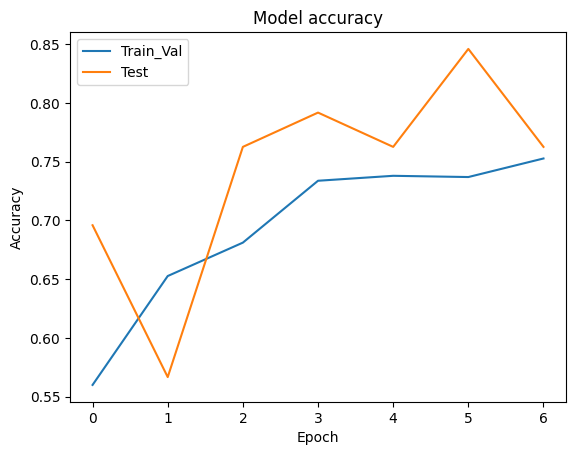

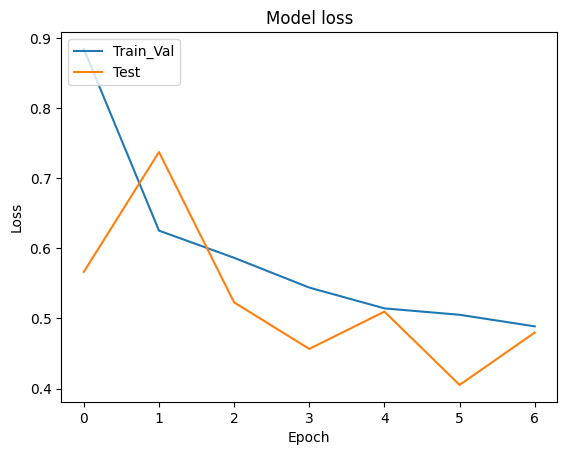

In [ ]:
# Plot training and validation accuracy curves
plt.plot(EfficientNetV2B0_history.history['accuracy'])
plt.plot(EfficientNetV2B0_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(EfficientNetV2B0_history.history['loss'])
plt.plot(EfficientNetV2B0_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the EfficientNetV2B0 model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_EfficientNetV2B0 = model.evaluate(test)
print('Test loss:', performance_EfficientNetV2B0[0])
print('Test accuracy:', performance_EfficientNetV2B0[1])

8/8 [==============================] - 49s 6s/step - loss: 0.4799 - accuracy: 0.7625 - recall: 0.8081 - precision: 0.8939
Test loss: 0.47988587617874146
Test accuracy: 0.762499988079071


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

8/8 [==============================] - 47s 6s/step
Accuracy: 0.7625
Precision: 0.8938547486033519
Recall: 0.8080808080808081
F1-score: 0.8488063660477454
F1_score_macro: 0.6477041538976591
AUC-ROC: 0.6778499278499279

              precision    recall  f1-score   support

           0       0.38      0.55      0.45        42
           1       0.89      0.81      0.85       198

    accuracy                           0.76       240
   macro avg       0.64      0.68      0.65       240
weighted avg       0.80      0.76      0.78       240



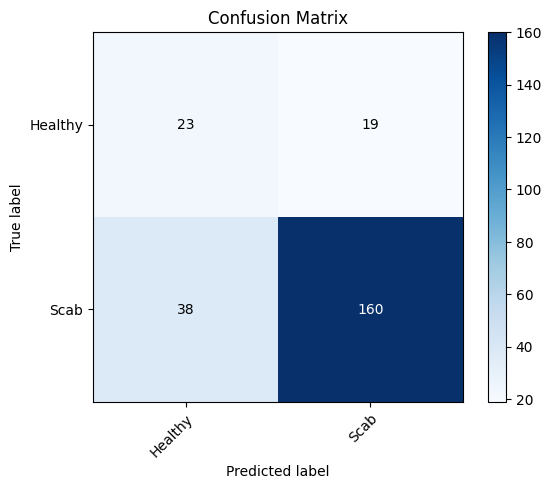

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title
ax.set_title("Confusion Matrix")

# Show the plot
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

# ConvNeXtTiny model:

## Perform hyperparameter tuning on the ConvNeXtTiny: model.

In [ ]:
def hp_fruits_ConvNeXtTiny(trail):

  clear_session()

  # preprocess data
  train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train.classes), y = train.classes)
  class_weights = {i : class_weights[i] for i in range(2)}

  # build model
  from tensorflow.keras.applications import ConvNeXtTiny
  from tensorflow.keras import layers

  ConvNeXtTiny_model = ConvNeXtTiny(input_shape = (224, 224, 3), 
                                  include_top = False, 
                                  weights = 'imagenet',
                                  include_preprocessing = False)

  for layer in ConvNeXtTiny_model.layers:
    layer.trainable = False

  last_output = ConvNeXtTiny_model.output
  x = layers.Flatten()(last_output)
  
  hidden_layers = trail.suggest_int('hidden_layers', 1, 2)

  for i in range(hidden_layers):
    first_neuron = trail.suggest_categorical('first_neuron', [128, 256, 512])
    x = layers.Dense(first_neuron, activation='relu')(x)
    drop_out = trail.suggest_categorical('drop_out', [0, 0.3, 0.5])
    x = layers.Dropout(drop_out)(x)                  
  
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(ConvNeXtTiny_model.input, x)

  # compile/train model
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'AdamW'])
  learning_rate = trail.suggest_float('lr', 1e-5, 1e-2, log=True)

  if optimizer_name == 'Adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'RMSprop':
      optimizer = RMSprop(learning_rate=learning_rate)
  elif optimizer_name == 'AdamW':
      optimizer = AdamW(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', Recall(), Precision()])
  
  early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  
  model.fit(train, validation_data=val, class_weight=class_weights, epochs = 100, callbacks=[early_stop])
  
  # Evaluate macro f1 score
  y_pred_val = model.predict(val)
  y_pred_val = np.round(y_pred_val)

  f1score_macro = f1_score(val.labels, y_pred_val, average = 'macro')
  print(f1score_macro)
  
  return f1score_macro

if __name__ == "__main__":
    warnings.warn(
        "Recent Keras release (2.4.0) simply redirects all APIs "
        "in the standalone keras package to point to tf.keras. "
        "There is now only one Keras: tf.keras. "
        "There may be some breaking changes for some workflows by upgrading to keras 2.4.0. "
        "Test before upgrading. "
        "REF:https://github.com/keras-team/keras/releases/tag/2.4.0"
    )
    study = optuna.create_study(direction="maximize")
    study.optimize(hp_fruits_ConvNeXtTiny, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<ipython-input-7-e91c3bbae14a>:67: UserWarning: Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  warnings.warn(
[I 2023-05-16 19:50:00,749] A new study created in memory with name: no-name-a3ea8c86-33db-4e74-b09c-a2692e2e5d30


Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
111650432/111650432 [==============================] - 4s 0us/step
Epoch 1/100
23/23 [==============================] - 415s 18s/step - loss: 5.4926 - accuracy: 0.5386 - recall: 0.5416 - precision: 0.8439 - val_loss: 0.4062 - val_accuracy: 0.8565 - val_recall: 0.9490 - val_precision: 0.8857
Epoch 2/100
23/23 [==============================] - 188s 8s/step - loss: 1.0817 - accuracy: 0.6213 - recall: 0.6282 - precision: 0.8789 - val_loss: 0.5224 - val_accuracy: 0.7595 - val_recall: 0.7500 - val_precision: 0.9484
Epoch 3/100
23/23 [==============================] - 187s 8s/step - loss: 0.8744 - accuracy: 0.6438 - recall: 0.6537 - precision: 0.8851 - val_loss: 0.6014 - val_accuracy: 0.6540 - val_recall: 0.6224 - val_precision: 0.9385
Epoch 4/100
23/23 [==============================] - 189s 8s/step - loss: 0.7879 - accuracy: 0.6

[I 2023-05-16 20:29:54,078] Trial 0 finished with value: 0.7525188383710101 and parameters: {'hidden_layers': 1, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.0008547677015733051}. Best is trial 0 with value: 0.7525188383710101.


0.7525188383710101
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 202s 8s/step - loss: 0.9129 - accuracy: 0.5273 - recall: 0.5450 - precision: 0.8231 - val_loss: 0.5558 - val_accuracy: 0.7300 - val_recall: 0.7551 - val_precision: 0.9024
Epoch 2/100
23/23 [==============================] - 188s 8s/step - loss: 0.7213 - accuracy: 0.6269 - recall: 0.6367 - precision: 0.8782 - val_loss: 0.7978 - val_accuracy: 0.4641 - val_recall: 0.3622 - val_precision: 0.9726
Epoch 3/100
23/23 [==============================] - 185s 8s/step - loss: 0.6987 - accuracy: 0.6438 - recall: 0.6435 - precision: 0.8960 - val_loss: 0.4158 - val_accuracy: 0.8270 - val_recall: 0.9439 - val_precision: 0.8605
Epoch 4/100
23/23 [==============================] - 189s 8s/step - loss: 0.6874 - accuracy: 0.6732 - recall: 0.6910 - precision: 0.8886 - val_lo

[I 2023-05-16 20:56:05,847] Trial 1 finished with value: 0.6247248291043911 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 3.444310855844599e-05}. Best is trial 0 with value: 0.7525188383710101.


0.6247248291043911
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 206s 9s/step - loss: 1.0688 - accuracy: 0.5849 - recall: 0.5959 - precision: 0.8582 - val_loss: 0.5261 - val_accuracy: 0.7342 - val_recall: 0.7806 - val_precision: 0.8844
Epoch 2/100
23/23 [==============================] - 184s 8s/step - loss: 0.6203 - accuracy: 0.6704 - recall: 0.6706 - precision: 0.9060 - val_loss: 0.4383 - val_accuracy: 0.8143 - val_recall: 0.8571 - val_precision: 0.9130
Epoch 3/100
23/23 [==============================] - 182s 8s/step - loss: 0.5589 - accuracy: 0.6957 - recall: 0.6859 - precision: 0.9266 - val_loss: 0.5426 - val_accuracy: 0.7426 - val_recall: 0.7296 - val_precision: 0.9470
Epoch 4/100
23/23 [==============================] - 185s 8s/step - loss: 0.5729 - accuracy: 0.7209 - recall: 0.7216 - precision: 0.9239 - val_lo

[I 2023-05-16 21:38:00,855] Trial 2 finished with value: 0.7788078646092583 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.000243929341233299}. Best is trial 2 with value: 0.7788078646092583.


0.7788078646092583
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 203s 8s/step - loss: 0.8969 - accuracy: 0.5386 - recall: 0.5569 - precision: 0.8283 - val_loss: 0.5879 - val_accuracy: 0.6540 - val_recall: 0.6582 - val_precision: 0.8958
Epoch 2/100
23/23 [==============================] - 183s 8s/step - loss: 0.7148 - accuracy: 0.5933 - recall: 0.5756 - precision: 0.8945 - val_loss: 0.5355 - val_accuracy: 0.7131 - val_recall: 0.7194 - val_precision: 0.9156
Epoch 3/100
23/23 [==============================] - 187s 8s/step - loss: 0.6593 - accuracy: 0.6255 - recall: 0.6180 - precision: 0.8966 - val_loss: 0.3971 - val_accuracy: 0.8270 - val_recall: 0.9490 - val_precision: 0.8571
Epoch 4/100
23/23 [==============================] - 190s 8s/step - loss: 0.6474 - accuracy: 0.6620 - recall: 0.6723 - precision: 0.8919 - val_lo

[I 2023-05-16 22:22:21,223] Trial 3 finished with value: 0.7817874008732069 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 3.7011574807773375e-05}. Best is trial 3 with value: 0.7817874008732069.


0.7817874008732069
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 199s 8s/step - loss: 1.0736 - accuracy: 0.5554 - recall: 0.5552 - precision: 0.8560 - val_loss: 0.6699 - val_accuracy: 0.5949 - val_recall: 0.5306 - val_precision: 0.9630
Epoch 2/100
23/23 [==============================] - 184s 8s/step - loss: 0.8676 - accuracy: 0.6003 - recall: 0.6231 - precision: 0.8535 - val_loss: 0.7156 - val_accuracy: 0.6034 - val_recall: 0.5357 - val_precision: 0.9722
Epoch 3/100
23/23 [==============================] - 183s 8s/step - loss: 0.7619 - accuracy: 0.6381 - recall: 0.6435 - precision: 0.8876 - val_loss: 0.5268 - val_accuracy: 0.7553 - val_recall: 0.7500 - val_precision: 0.9423
Epoch 4/100
23/23 [==============================] - 181s 8s/step - loss: 0.6904 - accuracy: 0.6620 - recall: 0.6655 - precision: 0.8991 - val_lo

[I 2023-05-16 23:18:30,866] Trial 4 finished with value: 0.7684981684981685 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0001709030011437925}. Best is trial 3 with value: 0.7817874008732069.


0.7684981684981685
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 207s 9s/step - loss: 0.8231 - accuracy: 0.6297 - recall: 0.6774 - precision: 0.8436 - val_loss: 0.6026 - val_accuracy: 0.6751 - val_recall: 0.7245 - val_precision: 0.8606
Epoch 2/100
23/23 [==============================] - 185s 8s/step - loss: 0.8019 - accuracy: 0.5947 - recall: 0.6163 - precision: 0.8521 - val_loss: 0.6548 - val_accuracy: 0.5949 - val_recall: 0.5765 - val_precision: 0.8968
Epoch 3/100
23/23 [==============================] - 183s 8s/step - loss: 0.7318 - accuracy: 0.5540 - recall: 0.5603 - precision: 0.8483 - val_loss: 0.5328 - val_accuracy: 0.7722 - val_recall: 0.8316 - val_precision: 0.8859
Epoch 4/100
23/23 [==============================] - 187s 8s/step - loss: 0.7028 - accuracy: 0.6283 - recall: 0.6570 - precision: 0.8600 - val_lo

[I 2023-05-17 00:12:41,318] Trial 5 finished with value: 0.7391414782829566 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 1.3947922815025808e-05}. Best is trial 3 with value: 0.7817874008732069.


0.7391414782829566
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 203s 8s/step - loss: 0.6864 - accuracy: 0.6129 - recall: 0.6299 - precision: 0.8648 - val_loss: 0.6837 - val_accuracy: 0.5485 - val_recall: 0.5000 - val_precision: 0.9159
Epoch 2/100
23/23 [==============================] - 185s 8s/step - loss: 0.6509 - accuracy: 0.6031 - recall: 0.5976 - precision: 0.8844 - val_loss: 0.5686 - val_accuracy: 0.7004 - val_recall: 0.7143 - val_precision: 0.9032
Epoch 3/100
23/23 [==============================] - 183s 8s/step - loss: 0.6204 - accuracy: 0.6059 - recall: 0.5908 - precision: 0.8969 - val_loss: 0.4186 - val_accuracy: 0.8439 - val_recall: 0.9490 - val_precision: 0.8732
Epoch 4/100
23/23 [==============================] - 186s 8s/step - loss: 0.6024 - accuracy: 0.6830 - recall: 0.6774 - precision: 0.9172 - val_lo

[I 2023-05-17 00:38:45,159] Trial 6 finished with value: 0.6701523415459846 and parameters: {'hidden_layers': 2, 'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 1.5300651962001827e-05}. Best is trial 3 with value: 0.7817874008732069.


0.6701523415459846
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 211s 9s/step - loss: 1.0398 - accuracy: 0.5414 - recall: 0.5620 - precision: 0.8275 - val_loss: 0.9182 - val_accuracy: 0.4557 - val_recall: 0.3622 - val_precision: 0.9467
Epoch 2/100
23/23 [==============================] - 187s 8s/step - loss: 0.8503 - accuracy: 0.5442 - recall: 0.5314 - precision: 0.8646 - val_loss: 0.8270 - val_accuracy: 0.5148 - val_recall: 0.4388 - val_precision: 0.9451
Epoch 3/100
23/23 [==============================] - 187s 8s/step - loss: 0.7160 - accuracy: 0.6101 - recall: 0.5908 - precision: 0.9039 - val_loss: 0.4906 - val_accuracy: 0.7553 - val_recall: 0.7908 - val_precision: 0.9012
Epoch 4/100
23/23 [==============================] - 189s 8s/step - loss: 0.6747 - accuracy: 0.6662 - recall: 0.6825 - precision: 0.8874 - val_lo

[I 2023-05-17 01:20:43,625] Trial 7 finished with value: 0.7179317640835758 and parameters: {'hidden_layers': 1, 'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 3.505849394692989e-05}. Best is trial 3 with value: 0.7817874008732069.


0.7179317640835758
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 206s 9s/step - loss: 8.2156 - accuracy: 0.5147 - recall: 0.5127 - precision: 0.8366 - val_loss: 0.6746 - val_accuracy: 0.7806 - val_recall: 0.8265 - val_precision: 0.9000
Epoch 2/100
23/23 [==============================] - 184s 8s/step - loss: 0.9188 - accuracy: 0.5386 - recall: 0.5331 - precision: 0.8533 - val_loss: 0.5849 - val_accuracy: 0.5485 - val_recall: 0.4847 - val_precision: 0.9406
Epoch 3/100
23/23 [==============================] - 185s 8s/step - loss: 0.7324 - accuracy: 0.2384 - recall: 0.1002 - precision: 0.8194 - val_loss: 0.7283 - val_accuracy: 0.2700 - val_recall: 0.1327 - val_precision: 0.8966
Epoch 4/100
23/23 [==============================] - 187s 8s/step - loss: 0.6572 - accuracy: 0.2875 - recall: 0.1579 - precision: 0.8857 - val_lo

[I 2023-05-17 01:53:22,021] Trial 8 finished with value: 0.7106227106227107 and parameters: {'hidden_layers': 1, 'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0036885776369435254}. Best is trial 3 with value: 0.7817874008732069.


0.7106227106227107
Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/100
23/23 [==============================] - 206s 9s/step - loss: 1.9154 - accuracy: 0.4979 - recall: 0.4873 - precision: 0.8367 - val_loss: 0.3641 - val_accuracy: 0.8312 - val_recall: 0.9745 - val_precision: 0.8451
Epoch 2/100
23/23 [==============================] - 189s 8s/step - loss: 0.6264 - accuracy: 0.6466 - recall: 0.6469 - precision: 0.8965 - val_loss: 0.4297 - val_accuracy: 0.8101 - val_recall: 0.8163 - val_precision: 0.9467
Epoch 3/100
23/23 [==============================] - 184s 8s/step - loss: 0.6292 - accuracy: 0.6788 - recall: 0.6740 - precision: 0.9147 - val_loss: 0.7146 - val_accuracy: 0.6245 - val_recall: 0.5612 - val_precision: 0.9735
Epoch 4/100
23/23 [==============================] - 186s 8s/step - loss: 0.5276 - accuracy: 0.7560 - recall: 0.7555 - precision: 0.9368 - val_lo

[I 2023-05-17 02:25:47,934] Trial 9 finished with value: 0.7814026577392137 and parameters: {'hidden_layers': 2, 'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0007979883477950347}. Best is trial 3 with value: 0.7817874008732069.


0.7814026577392137
Number of finished trials: 10
Best trial:
  Value: 0.7817874008732069
  Params: 
    hidden_layers: 2
    first_neuron: 512
    drop_out: 0.3
    optimizer: Adam
    lr: 3.7011574807773375e-05


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_hidden_layers,params_lr,params_optimizer,state
0,0,0.752519,2023-05-16 19:50:00.752501,2023-05-16 20:29:54.077707,0 days 00:39:53.325206,0.3,512,1,0.000855,RMSprop,COMPLETE
1,1,0.624725,2023-05-16 20:29:54.079459,2023-05-16 20:56:05.847063,0 days 00:26:11.767604,0.3,512,2,0.000034,RMSprop,COMPLETE
2,2,0.778808,2023-05-16 20:56:05.848668,2023-05-16 21:38:00.855264,0 days 00:41:55.006596,0.0,128,1,0.000244,Adam,COMPLETE
3,3,0.781787,2023-05-16 21:38:00.856773,2023-05-16 22:22:21.223323,0 days 00:44:20.366550,0.3,512,2,0.000037,Adam,COMPLETE
4,4,0.768498,2023-05-16 22:22:21.224713,2023-05-16 23:18:30.865823,0 days 00:56:09.641110,0.3,512,2,0.000171,AdamW,COMPLETE
5,5,0.739141,2023-05-16 23:18:30.867635,2023-05-17 00:12:41.317888,0 days 00:54:10.450253,0.3,256,2,0.000014,RMSprop,COMPLETE
6,6,0.670152,2023-05-17 00:12:41.319655,2023-05-17 00:38:45.159456,0 days 00:26:03.839801,0.0,256,2,0.000015,AdamW,COMPLETE
7,7,0.717932,2023-05-17 00:38:45.160944,2023-05-17 01:20:43.624823,0 days 00:41:58.463879,0.5,256,1,0.000035,AdamW,COMPLETE
8,8,0.710623,2023-05-17 01:20:43.626325,2023-05-17 01:53:22.021175,0 days 00:32:38.394850,0.5,128,1,0.003689,Adam,COMPLETE
9,9,0.781403,2023-05-17 01:53:22.022675,2023-05-17 02:25:47.934186,0 days 00:32:25.911511,0.0,512,2,0.000798,AdamW,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
from google.colab import runtime
runtime.unassign()

## Re-train the ConvNeXtTiny model using the best hyperparameters.

In [ ]:
clear_session()

from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras import layers

# preprocess data
train, val, train_val, test = train_val_test_generators(train_dir, val_dir, train_val_dir, test_dir)

class_weights_train_val = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_val.classes), y = train_val.classes)
class_weights_train_val = {i : class_weights_train_val[i] for i in range(2)}

# get best hyperparameters
best_hidden_layers = 2 #study.best_params['hidden_layers']
best_neurons = 512 #study.best_params['first_neuron']
best_dropout = 0.3 #study.best_params['drop_out']
best_optimizer = 'Adam' #study.best_params['optimizer']
best_lr = 0.000037	 #study.best_params['lr']
epochs = 9# take best epoch from HP tuning trail


ConvNeXtTiny_model = ConvNeXtTiny(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in ConvNeXtTiny_model.layers:
  layer.trainable = False

last_output = ConvNeXtTiny_model.output
x = layers.Flatten()(last_output)

for i in range(best_hidden_layers):
  x = layers.Dense(best_neurons, activation='relu')(x)
  x = layers.Dropout(best_dropout)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(ConvNeXtTiny_model.input, x) 

if best_optimizer == 'Adam':
    optimizer = Adam(learning_rate=best_lr)
elif best_optimizer == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_lr)
elif best_optimizer == 'AdamW':
    optimizer = AdamW(learning_rate=best_lr)


model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', Recall(), Precision()])

ConvNeXtTiny_history = model.fit(train_val, validation_data=test, # test set used only for monitoring loss and accuracy, not for HP tuning
                                 class_weight=class_weights_train_val, epochs = epochs,
                                 max_queue_size=40, workers=4, use_multiprocessing=True)

Found 713 images belonging to 2 classes.
Found 237 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
111650432/111650432 [==============================] - 4s 0us/step
Epoch 1/9
30/30 [==============================] - 152s 4s/step - loss: 0.8729 - accuracy: 0.5695 - recall: 0.5962 - precision: 0.8357 - val_loss: 0.4962 - val_accuracy: 0.8042 - val_recall: 0.9040 - val_precision: 0.8647
Epoch 2/9
30/30 [==============================] - 100s 3s/step - loss: 0.7194 - accuracy: 0.5579 - recall: 0.5452 - precision: 0.8717 - val_loss: 0.6770 - val_accuracy: 0.5750 - val_recall: 0.5404 - val_precision: 0.9068
Epoch 3/9
30/30 [==============================] - 86s 3s/step - loss: 0.6598 - accuracy: 0.6053 - recall: 0.5924 - precision: 0.8942 - val_loss: 0.5002 - val_accuracy: 0.7750 - val_recall: 0.8232 - val_precision: 0.8956
Epoch 4/9
30/30 [==============================] - 85s 3s/step - loss: 0.6481 - accuracy: 0.6105 - recal

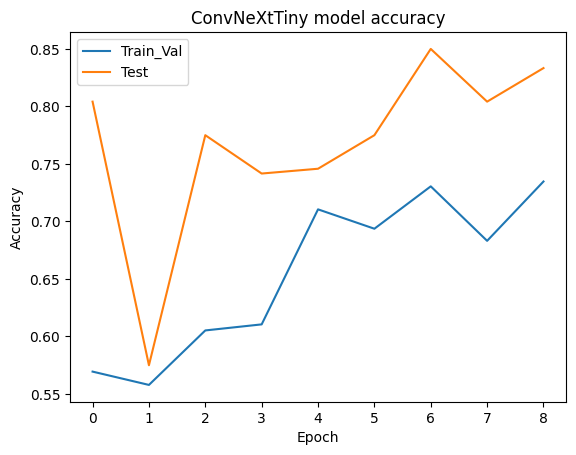

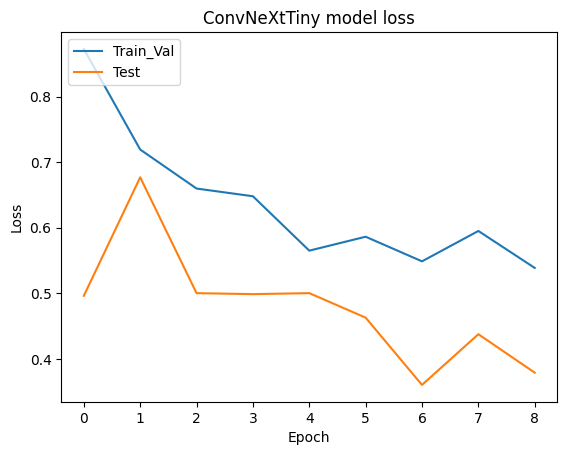

In [ ]:
# Plot training and validation accuracy curves
plt.plot(ConvNeXtTiny_history.history['accuracy'])
plt.plot(ConvNeXtTiny_history.history['val_accuracy'])
plt.title('ConvNeXtTiny model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss curves
plt.plot(ConvNeXtTiny_history.history['loss'])
plt.plot(ConvNeXtTiny_history.history['val_loss'])
plt.title('ConvNeXtTiny model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_Val', 'Test'], loc='upper left')
plt.show()

## Test the performance of the ConvNeXtTiny model on the test set.

In [ ]:
# Evaluate model performance on test set
performance_ConvNeXtTiny = model.evaluate(test)
print('Test loss:', performance_ConvNeXtTiny[0])
print('Test accuracy:', performance_ConvNeXtTiny[1])

8/8 [==============================] - 43s 5s/step - loss: 0.3789 - accuracy: 0.8333 - recall: 0.9192 - precision: 0.8835
Test loss: 0.37892135977745056
Test accuracy: 0.8333333134651184


In [ ]:
# Use the trained model to predict on the test set and round the prediction
y_pred = model.predict(test)
y_pred = np.round(y_pred)

# Calculate the evaluation metrics
accuracy = accuracy_score(test.labels, y_pred)
precision = precision_score(test.labels, y_pred)
recall = recall_score(test.labels, y_pred)
f1score = f1_score(test.labels, y_pred)
f1score_macro = f1_score(test.labels, y_pred, average = 'macro')
auc_roc = roc_auc_score(test.labels, y_pred)

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(test.labels, y_pred))

8/8 [==============================] - 45s 5s/step
Accuracy: 0.8333333333333334
Precision: 0.883495145631068
Recall: 0.9191919191919192
F1-score: 0.9009900990099011
F1_score_macro: 0.6873371547681084
AUC-ROC: 0.6738816738816739

              precision    recall  f1-score   support

           0       0.53      0.43      0.47        42
           1       0.88      0.92      0.90       198

    accuracy                           0.83       240
   macro avg       0.71      0.67      0.69       240
weighted avg       0.82      0.83      0.83       240



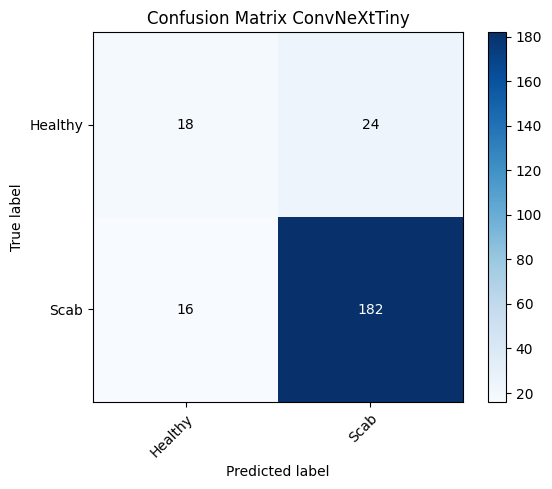

In [ ]:
# Create a confusion matrix:
cm = confusion_matrix(test.labels, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny")
plt.show()